(5, 1, 2)


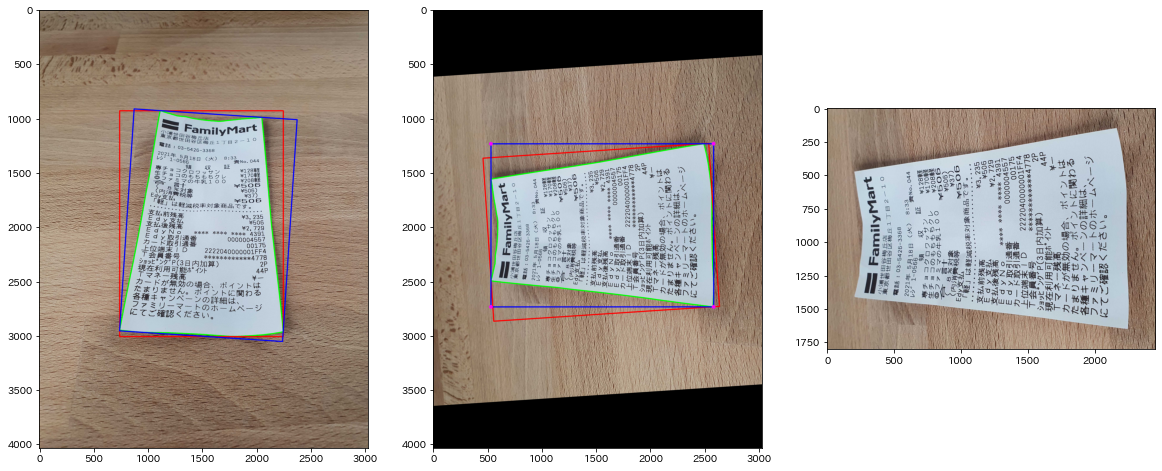

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import os
import face_recognition
from shapely.geometry import MultiPolygon, LinearRing, Polygon, LineString, MultiLineString
from shapely import ops
from scipy import ndimage
# from collections import Counter
from scipy import ndimage
from scipy.spatial import distance
import random
import itertools


path = '../data/ticket_test_1.jpg'
img = cv2.imread(path)[:, :, [2, 1, 0]]

# Find ticket's contour in image
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
# img_gray = cv2.Canny(img_gray, 75, 200)

_, thresh = cv2.threshold(img_gray, 175, 255, cv2.THRESH_BINARY)
thresh_rgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(contours[0].shape)
contours = list(filter(lambda x: cv2.contourArea(x) > 5000, contours))

cnt = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 10)

x, y, w, h = cv2.boundingRect(contours[0])
cnt = cv2.rectangle(cnt,(x,y), (x+w,y+h), (255,0,0), 10)

rect = cv2.minAreaRect(contours[0])
box = np.int0(cv2.boxPoints(rect))
cnt = cv2.drawContours(cnt,[box],0,(0,0,255),10)

center = rect[0]
angle = rect[2]

rot = cv2.getRotationMatrix2D(center, angle+90, 1)
img_warp = cv2.warpAffine(cnt, rot, (cnt.shape[1], cnt.shape[0]))
warp = cv2.warpAffine(img, rot, (cnt.shape[1], cnt.shape[0]))

# Rotate points
pts_expand = np.hstack([box, np.ones(shape=(box.shape[0], 1))])
pts_dst = np.uint(rot.dot(pts_expand.T).T)

# Plot rotated points
for i in pts_dst:
    img_warp = cv2.circle(img_warp, (i[0], i[1]), 7, (255,0,255), 20)

# # Get corresponding bounding box features
x_warp, y_warp, w_warp, h_warp = cv2.boundingRect(pts_dst.astype(int))
off_h, off_w = 0.1, 0.1
m_h, m_w = int(off_h*h_warp), int(off_w*w_warp)

warp = warp[y_warp-m_h:y_warp + h_warp + m_h, x_warp-m_w:x_warp + w_warp + m_w]

# Plot results
plt.figure(figsize = (20,20))
plt.subplot(1,3,1)
plt.imshow(cnt)

plt.subplot(1,3,2)
plt.imshow(img_warp)

plt.subplot(1,3,3)
plt.imshow(warp)

In [2]:
def sort_points(pts):
    pts_sort = pts[np.argsort(pts[:,1])]
    pts_sort = np.array([pts_sort[np.argmin(pts_sort[:2,0])],
                         pts_sort[np.argmax(pts_sort[:2,0])],
                         pts_sort[np.argmax(pts_sort[2:,0])+2],
                         pts_sort[np.argmin(pts_sort[2:,0])+2]])

    ratio = (pts_sort[2,0] - pts_sort[3,0]) / (pts_sort[1,0] - pts_sort[0,0])

    return pts_sort, ratio

def extend_coord(pts1, pts2, factor=1.05):
    t0=0.5*(1.0-factor)
    t1=0.5*(1.0+factor)
    x1 = int(pts1[0] +(pts2[0] - pts1[0]) * t0)
    y1 = int(pts1[1] +(pts2[1] - pts1[1]) * t0)
    x2 = int(pts1[0] +(pts2[0] - pts1[0]) * t1)
    y2 = int(pts1[1] +(pts2[1] - pts1[1]) * t1)
    return [(x1,y1),(x2,y2)]

def coord_contour(r,p,axis):
    inter = r.intersection(p)
    if inter.geom_type == 'MultiLineString':
        inter = ops.linemerge(inter)
    cnt = np.array([inter.coords]).reshape(-1,2).astype(int)
    return cnt[np.argsort(cnt[:,axis])]

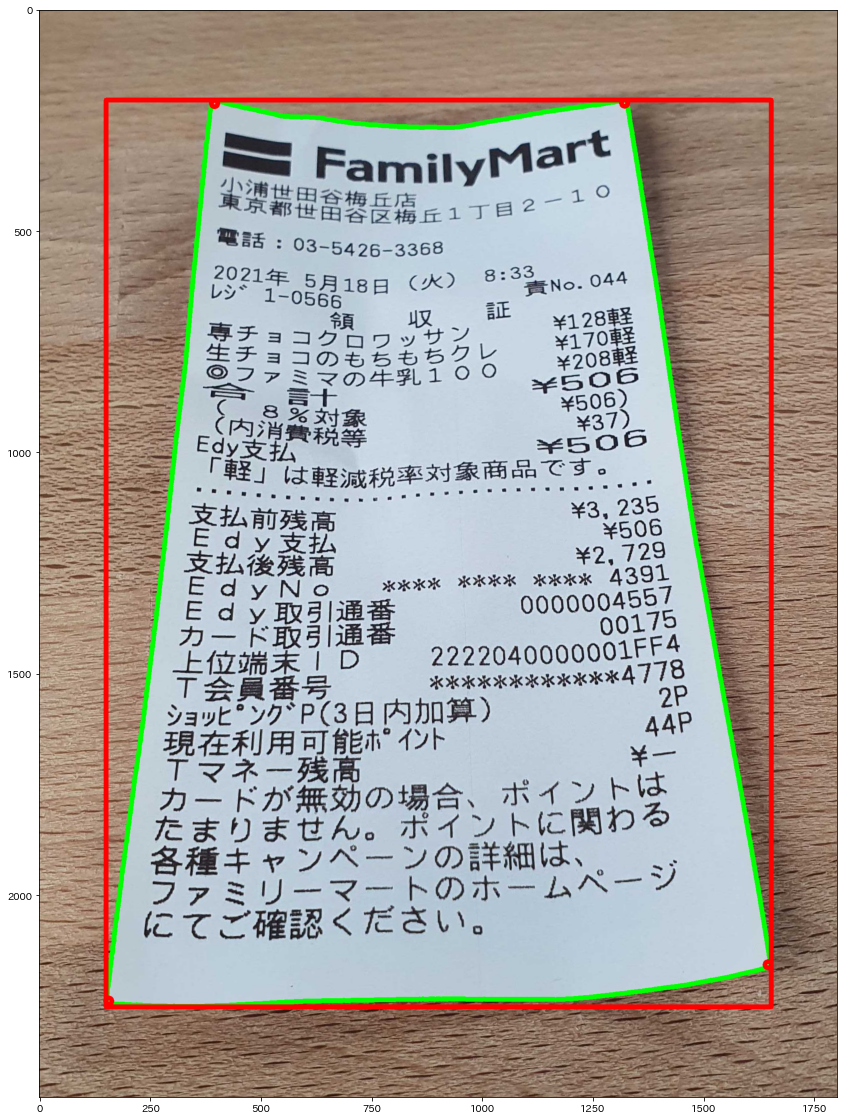

In [3]:
# Find ticket's contour in image
img_gray = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
# img_gray = cv2.Canny(img_gray, 75, 200)

_, thresh = cv2.threshold(img_gray, 175, 255, cv2.THRESH_BINARY)
thresh_rgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
_, contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = list(filter(lambda x: cv2.contourArea(x) > 5000, contours))

img_corner = cv2.drawContours(warp.copy(), contours, -1, (0, 255, 0), 10)

overlay = np.ones(warp.shape)*255
mask = cv2.fillPoly(overlay, contours, color=(0, 0, 0))
gray = np.float32(cv2.cvtColor(mask.astype(np.uint8),cv2.COLOR_RGB2GRAY))

dst = cv2.cornerHarris(gray,50,3,0.04)
ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)

ret, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(dst))
pts_src, ratio = sort_points(centroids[1:].astype(int))

for i in pts_src:
    img_corner = cv2.circle(img_corner, (i[0], i[1]), 7, (255,0,0), 10)

x, y, w, h = cv2.boundingRect(contours[0])
img_corner = cv2.rectangle(img_corner,(x,y), (x+w,y+h), (255,0,0), 10)

pts_dst = np.array([[x,y],
                    [x+w,y],
                    [x+w,ratio*(y+h)],
                    [x,ratio*(y+h)]]).astype(int)

plt.figure(figsize = (20,20))
plt.imshow(img_corner)

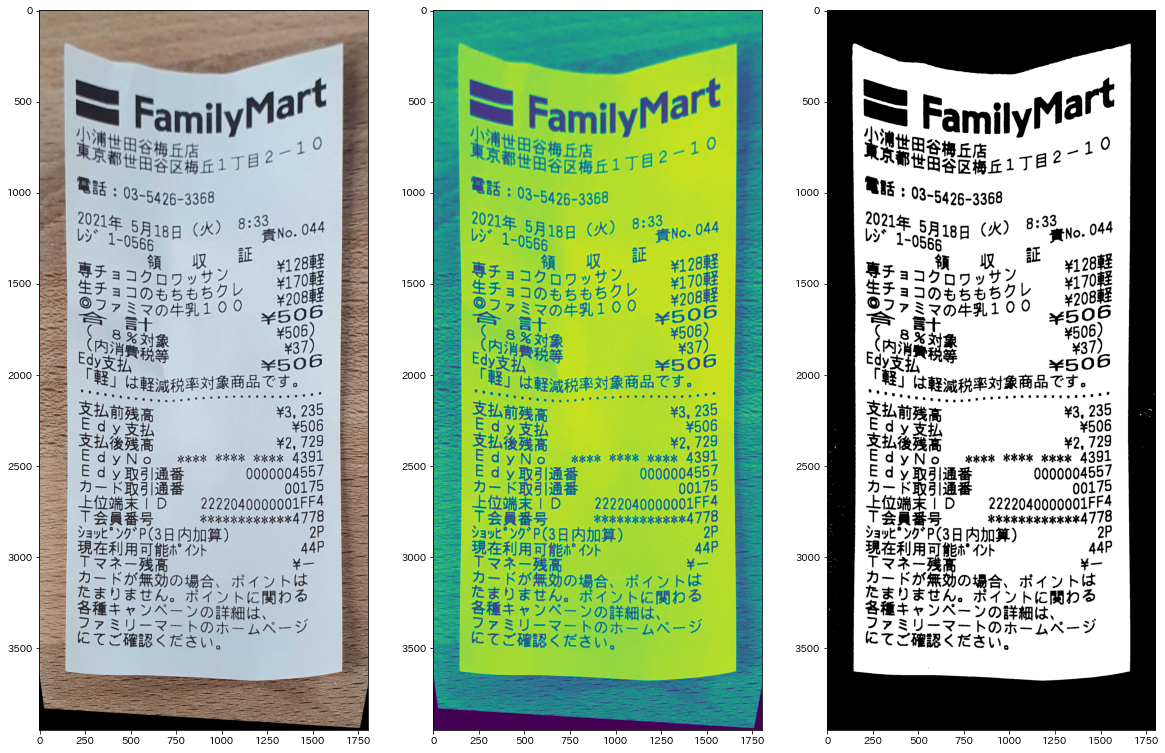

In [4]:
# pts_src and pts_dst are numpy arrays of points in source and destination images. We need at least corresponding points.
h, status = cv2.findHomography(pts_src, pts_dst)

height, width = img_corner.shape[:2]

# The calculated homography can be used to warp the source image to destination. Size is the size (width,height) of im_dst
img_dst = cv2.warpPerspective(warp.copy(), h, (width,int(height*ratio)))

# Thresholding
img_gray = cv2.cvtColor(img_dst, cv2.COLOR_BGR2GRAY)
img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
# img_gray = cv2.Canny(img_gray, 75, 200)

_, thresh = cv2.threshold(img_gray, 175, 255, cv2.THRESH_BINARY)
thresh_rgb = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

plt.figure(figsize = (20,20))
plt.subplot(1,3,1)
plt.imshow(img_dst)

plt.subplot(1,3,2)
plt.imshow(img_gray)

plt.subplot(1,3,3)
plt.imshow(thresh_rgb)

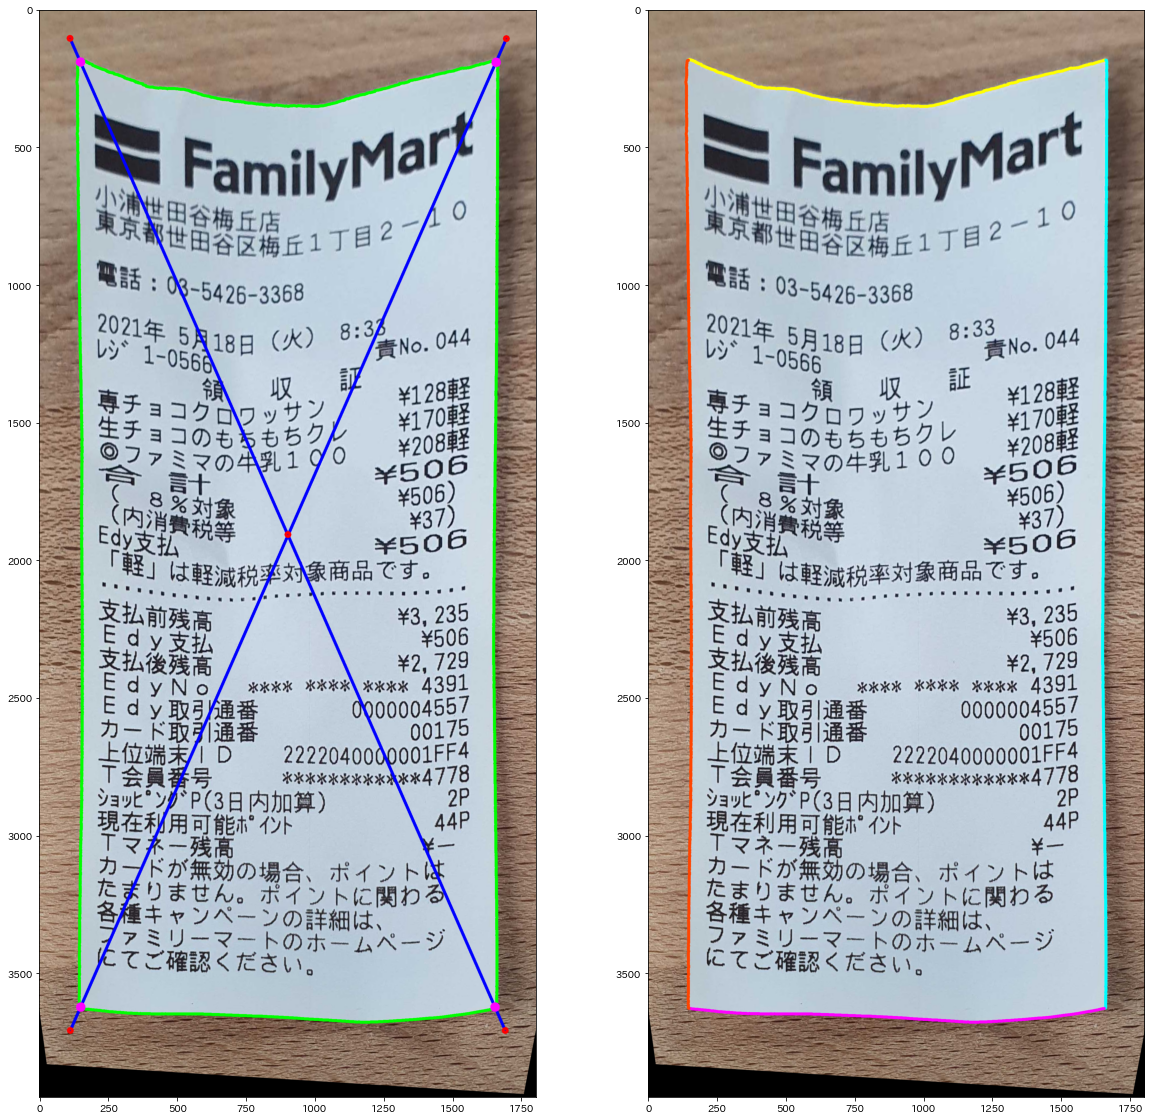

In [5]:
res = img_dst.copy()
res_cnt = img_dst.copy()

_, contours, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = list(filter(lambda x: cv2.contourArea(x) > 5000, contours))[0]

overlay = np.ones(thresh.shape)*255
gray = np.float32(cv2.fillPoly(overlay, [contours], color=(0, 0, 0)))
dst = cv2.cornerHarris(gray,50,3,0.04)

ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)

ret, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(dst))
edges, _ = sort_points(centroids[1:].astype(int))

# Get keypoints
centroid = np.array((sum(edges[:,0]) / len(edges), sum(edges[:,1]) / len(edges))).astype(int)
pts_tl_br = extend_coord(edges[0],edges[2])
pts_tr_bl = extend_coord(edges[1],edges[3])

# Find interesection between line and polygon
ring = LinearRing(contours.squeeze().tolist())

poly = Polygon(np.array([centroid,pts_tl_br[0], pts_tr_bl[0]]))
cnt_top = coord_contour(ring, poly, 0)

poly = Polygon(np.array([centroid,pts_tr_bl[0], pts_tl_br[1]]))
cnt_right = coord_contour(ring, poly, 1)

poly = Polygon(np.array([centroid,pts_tl_br[1],pts_tr_bl[1]]))
cnt_bot = coord_contour(ring, poly, 0)

poly = Polygon(np.array([centroid,pts_tr_bl[1],pts_tl_br[0]]))
cnt_left = coord_contour(ring, poly, 1)

# Plot results
res = cv2.drawContours(res, [contours], -1, (0, 255, 0), 10)
res = cv2.line(res, pts_tl_br[0], pts_tl_br[1], (0, 0, 255), 10)
res = cv2.line(res, pts_tr_bl[0], pts_tr_bl[1], (0, 0, 255), 10)

for i in edges:
    res = cv2.circle(res, (i[0], i[1]), 7, (255,0,0), 10)
res = cv2.circle(res, (centroid[0],centroid[1]), 7, (255,0,0), 10)
for i in pts_tl_br:
    res = cv2.circle(res, (i[0], i[1]), 7, (255,0,0), 10)
for i in pts_tr_bl:
    res = cv2.circle(res, (i[0], i[1]), 7, (255,0,0), 10)

res_cnt = cv2.polylines(res_cnt, [cnt_top], 0, (255, 255, 0), 10)
res_cnt = cv2.polylines(res_cnt, [cnt_right], 0, (0, 255, 255), 10)
res_cnt = cv2.polylines(res_cnt, [cnt_bot], 0, (255, 0, 255), 10)
res_cnt = cv2.polylines(res_cnt, [cnt_left], 0, (255,69,0), 10)

for i in edges:
    res = cv2.circle(res, (i[0], i[1]), 7, (255,0,255), 20)

plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(res)

plt.subplot(1,2,2)
plt.imshow(res_cnt)

In [44]:
import sys
row = 10
col = 5

cnt_pts = img_dst.copy()

# Linear distance grid retrieval
top_dist = distance.cdist(cnt_top, cnt_top, 'euclidean')[0]
idx_top = [0] + [np.argmin(np.abs(top_dist-i)) for i in list(np.arange(0 , col)*(top_dist[-1] / (col-1)))[1:-1]]+ [len(top_dist)-1]
top_pts = cnt_top[idx_top]

right_dist = distance.cdist(cnt_right, cnt_right, 'euclidean')[0]
idx_right = [0] + [np.argmin(np.abs(right_dist-i)) for i in list(np.arange(0 , row)*(right_dist[-1] / (row-1)))[1:-1]]+ [len(right_dist)-1]
right_pts = cnt_right[idx_right]

bot_dist = distance.cdist(cnt_bot, cnt_bot, 'euclidean')[0]
idx_bot = [0] + [np.argmin(np.abs(bot_dist-i)) for i in list(np.arange(0 , col)*(bot_dist[-1] / (col-1)))[1:-1]]+ [len(bot_dist)-1]
bot_pts = cnt_bot[idx_bot]

left_dist = distance.cdist(cnt_left, cnt_left, 'euclidean')[0]
idx_left = [0] + [np.argmin(np.abs(left_dist-i)) for i in list(np.arange(0 , row)*(left_dist[-1] / (row-1)))[1:-1]]+ [len(left_dist)-1]
left_pts = cnt_left[idx_left]

pts = []

# [[146, 185], [509, 290], [887, 351], [1276, 281], [1659, 185]]

for r, c in list(itertools.product(list(range(row)), list(range(col)))):
    if r==0:
        pts.append(top_pts[c].tolist())
    elif r == row-1:
        pts.append(bot_pts[c].tolist())
    else:
        x = np.average([left_pts[r][0], right_pts[r][0]], weights=[(col -1 -c)/(col-1), c/(col -1)])
        y = np.average([top_pts[c][1], bot_pts[c][1]], weights=[(row -1 -r)/(row-1), r/(row-1)])
        pts.append([int(x),int(y)])

pts_grid = []

x = np.linspace(left_pts[0][0], right_pts[0][0], col)
y = np.linspace(top_pts[0][1], bot_pts[0][1], row)
xv, yv = np.meshgrid(x, y)

pts_grid = list(zip(xv.ravel().astype(int).tolist(),yv.ravel().astype(int).tolist()))


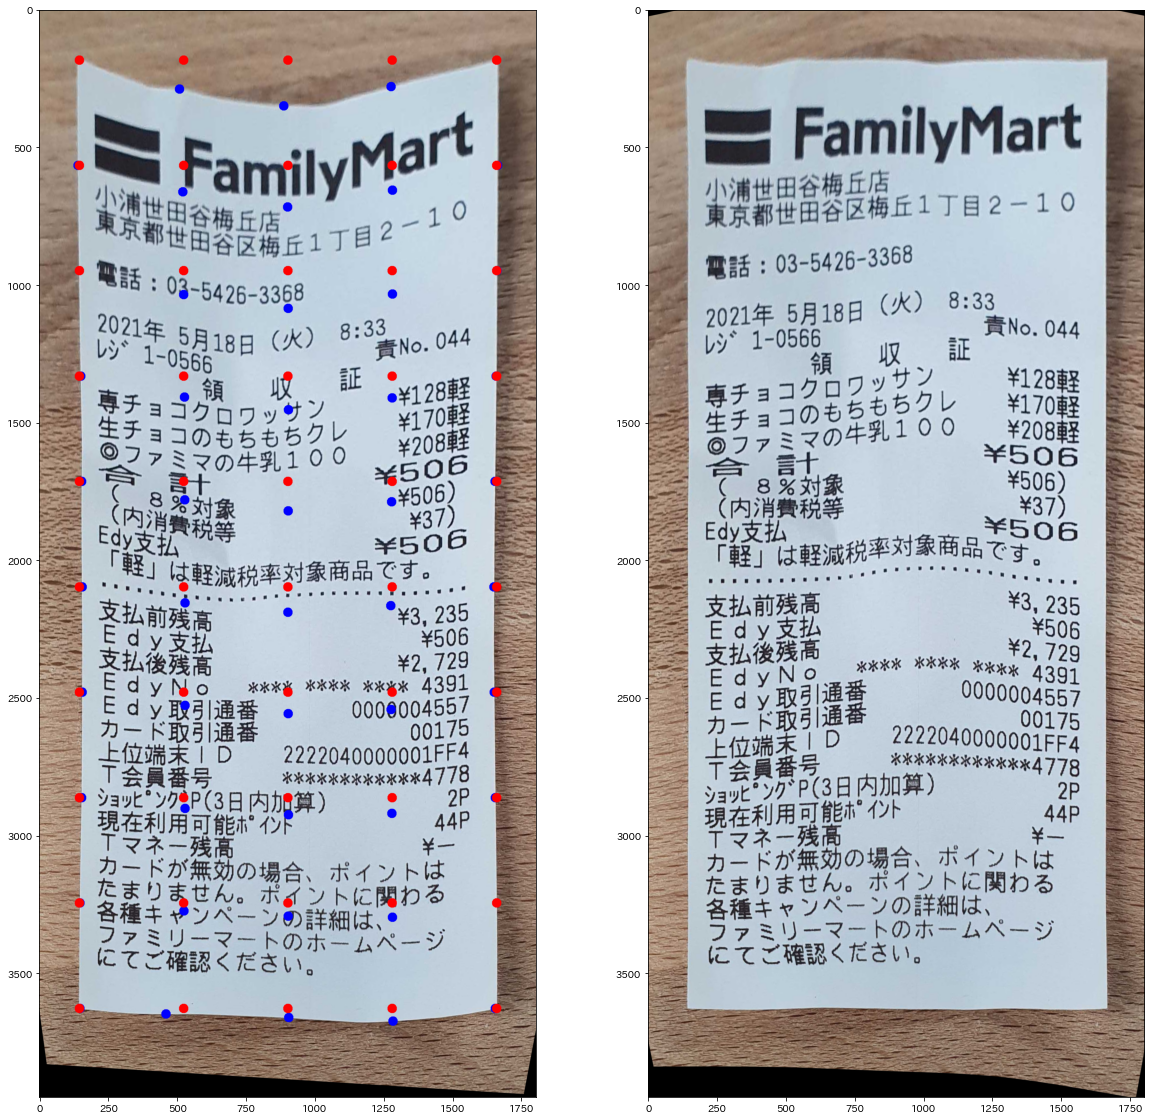

In [46]:
for i in pts:
    cnt_pts = cv2.circle(cnt_pts, (i[0], i[1]), 7, (0,0,255), 20)

for i in pts_grid:
    cnt_pts = cv2.circle(cnt_pts, (i[0], i[1]), 7, (255,0,0), 20)
    
tps = cv2.createThinPlateSplineShapeTransformer()
matches = [cv2.DMatch(i, i, 0) for i in range(len(pts))]

tps.estimateTransformation(np.array(pts_grid).reshape(1,-1,2), np.array(pts).reshape(1,-1,2), matches)
out_img = tps.warpImage(img_dst.copy())
    
plt.figure(figsize = (20,20))

plt.subplot(1,2,1)
plt.imshow(cnt_pts)

plt.subplot(1,2,2)
plt.imshow(out_img)